In [1070]:
import os
import glob
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms

In [1071]:
def _imshow1(_img):
    plt.figure()
    plt.axis("off")

    if len(_img.shape) == 3 and _img.shape[-1] not in {1, 3, 4}:
        return plt.imshow(_img.permute(1, 2, 0))
    plt.imshow(_img, interpolation="nearest")


def imshow(_img, _mask=None):
    _img -= _img.min()
    _img /= _img.max()
    
    if _mask is None:
        return _imshow1(_img)

    _, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.axis("off")
    ax2.axis("off")

    ax1.imshow(_img.permute(1, 2, 0), interpolation="nearest")
    ax2.imshow(_mask, interpolation="nearest")


def get_img_dataset_normalisation(dataset):
    data = np.array([np.array(_img) for _img in dataset])
    mean = data.mean(axis=(0, -1, -2))
    std = data.std(axis=(0, -1, -2))
    return mean, std

In [1072]:
class KeyboardDataset(Dataset):
    def __init__(self, _imgs, _transforms=()):
        self._images = _imgs
        self._transforms = transforms.Compose(_transforms)

    def __getitem__(self, idx):
        _img = Image.open(self._images[idx])
        _img = self._transforms(_img)
        return _img

    def __len__(self):
        return len(self._images)


class BinaryKeyboardSegmentationDataset(Dataset):
    def __init__(self, _imgs, _transforms=(), _augmentations=()):
        self._images = _imgs
        self._masks = list(map(lambda p: f"blender/masks/keyboard_{os.path.basename(p)[:3]}.png", _imgs))

        self._transforms = transforms.Compose(_transforms)
        self._augmentations = transforms.Compose(_augmentations)

    def __getitem__(self, idx):
        _img = Image.open(self._images[idx])

        _mask = Image.open(self._masks[idx]).convert("RGB")

        _img, _mask = self._transforms(_img, _mask)
        _img = self._augmentations(_img)
        _mask = _mask[0, :, :]
        _mask = (_mask > 1)

        return _img, _mask

    def __len__(self):
        return len(self._images)


In [1073]:
image_paths = glob.glob("assets/keyboards/**")
random.shuffle(image_paths)

dataset = KeyboardDataset(random.sample(image_paths, k=500), [transforms.ToImage(),
                                                              transforms.ToDtype(torch.float32, scale=True)])

mean, stdev = get_img_dataset_normalisation(dataset)
mean, stdev

/var/folders/r5/mzzh3rn14lgb2__wr5h7swqm0000gn/T/ipykernel_73540/733965853.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.array([np.array(_img) for _img in dataset])


(array([0.24483441, 0.25867277, 0.2684216 ], dtype=float32),
 array([0.23372015, 0.24013205, 0.2498956 ], dtype=float32))

In [1074]:
transform = [
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.RandomErasing(p=0.5),
]

augmentation = [
    transforms.RandomChannelPermutation(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.Normalize(mean, stdev),
]

In [1075]:
val_size = int(len(image_paths) * 0.16)
train_size = int(len(image_paths) * 0.8)

val_paths = image_paths[:val_size]
train_paths = image_paths[val_size:train_size]
test_paths = image_paths[train_size:]

train_dataset = BinaryKeyboardSegmentationDataset(train_paths, transform, augmentation)
val_dataset = BinaryKeyboardSegmentationDataset(val_paths, transform, augmentation)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, transform, augmentation)

len(train_dataset), len(val_dataset), len(test_dataset)

(640, 160, 200)

53


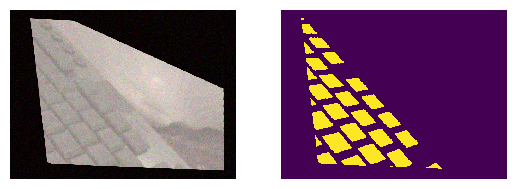

In [1076]:
i = random.randint(0, len(train_dataset) - 1)
print(i)
img, mask = train_dataset[i]

imshow(img, mask)

In [1077]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64, shuffle=True)